In [1]:
# reload
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import funPlots as fplot

import seaborn as sns
from scipy.stats import entropy

fplot.master_format(ncols = 2, nrows = 2)

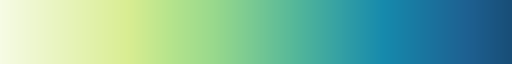

In [3]:
import matplotlib.patheffects as pe
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ["#F6FBE4", "#ECF6C9", "#E3F2AE", "#d9ed92", "#b5e48c", "#99d98c",
          "#76c893", "#52b69a", "#34a0a4", "#168aad", "#1a759f", "#1e6091", "#184e77"]
nodes = np.linspace(0, 1, len(colors))
cmap_SR = LinearSegmentedColormap.from_list("cmap_SR", list(zip(nodes, colors)))
cmap_SR.set_bad(color='w')
cmap_SR

In [4]:
from utils.simulation import *
from utils.mutual import (compute_mutual_information_from_trajectories, mutual_information_slowjumps, MC_underhood)
from utils.analytical import *

def get_default_params_system():
    ### Info system
    N = 2
    w = 2
    k = 1.1
    tau_ei = 1
    r = np.ones(N)
    
    return {'N': N, 'w': w, 'k': k, 'tau_ei': tau_ei, 'r': r}

In [5]:
data_folder = 'data/'

mutuals = np.load(data_folder+'mutual_importance_sampling.npy')
my_cmap_continuous = sns.color_palette('mako_r', as_cmap=True)

colors = ("#76c893", "#184e77")
labels = ('$E$', '$I$')

In [6]:
w = 5
k = 1.1
sigmah = 1

k = 1.1
wlist = [1, 3.5, 6, 10]

tmin = -1
tmax = 6
dt = 0.01

ts = np.arange(0, tmax, dt)
tstim = np.arange(tmin, tmax, dt)

### Compute mutual
I_t = [mutual_time_dependent(w, k, sigmah, ts) for w in wlist]
I_t = np.array(I_t)

In [7]:
kmin, kmax = 0.01, 5
wmin, wmax = 1, 10

nk, nw = int(1e3), int(5e2)

ws = np.linspace(wmin, wmax, nw)
Ks = np.zeros((nw, nk))
Ws = np.zeros((nw, nk))

for idx_w, w in enumerate(ws):
    kcrit = 1 - 1/w
    if w <=1:
        k_list = np.linspace(kmin, kmax, nk)
    else:
        k_list = np.geomspace(1e-12, kcrit/2, 500) + kcrit
        k_list = np.concatenate([np.linspace(kcrit*(1 + 1/2), kmax, nk - 500), k_list])
    Ks[idx_w] = np.sort(k_list)
    Ws[idx_w] = w

unstable = np.where(1 + Ws*(Ks-1)<=0)

Istat = np.zeros(Ks.shape)
SDer = np.zeros(Ks.shape)

for idx_w, w in enumerate(ws):
    for idx_k, k in enumerate(Ks[idx_w]):
        if 1 + w*(k-1)<=0:
            Istat[idx_w, idx_k] = np.nan
            SDer[idx_w, idx_k] = np.nan
        else:
            Istat[idx_w, idx_k] = mutual_stat_input(w, k, sigmah)
            SDer[idx_w, idx_k] = mutual_second_der(w, k, sigmah)

Istat /= np.log(2)
SDer /= np.log(2)

/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_41303/2346711551.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axs["cp_chi"].pcolormesh(Ks, Ws, SDer, cmap=cmap_SR, rasterized = True)
/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_41303/2346711551.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axs["cp_ist"].pcolormesh(Ks, Ws, np.log10(Istat), cmap=cmap_SR, rasterized = True)


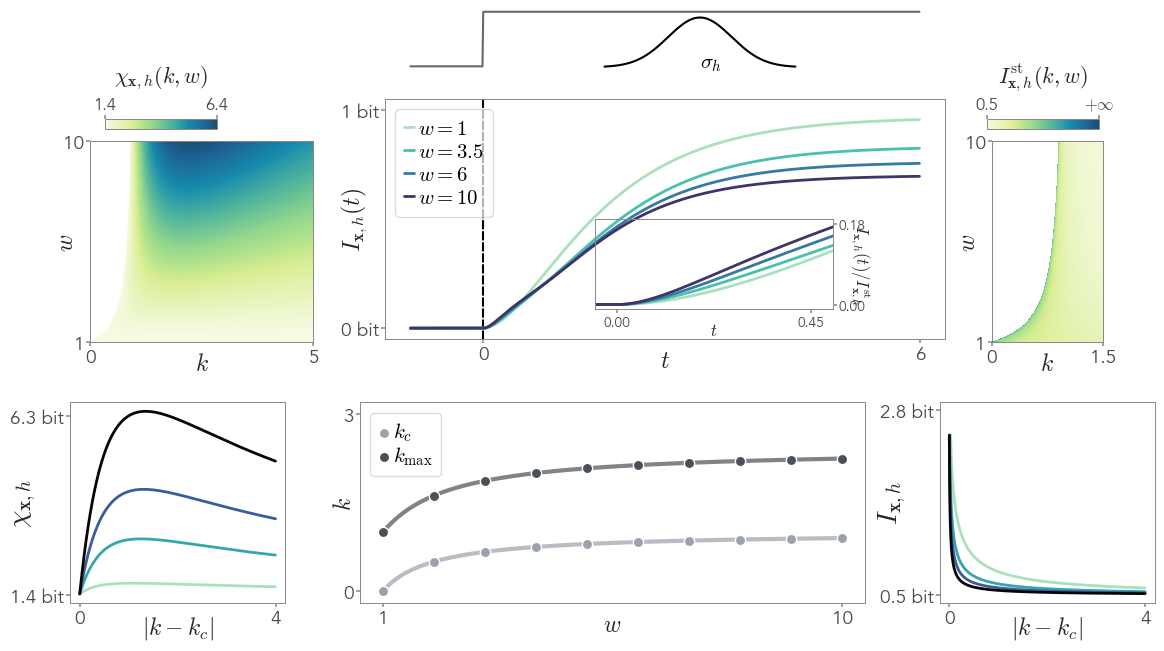

In [20]:
fig, axs = plt.subplot_mosaic([["cp_chi", "cp_chi", "time", "time", "time", ".","cp_ist"],
                               ["chi", ".", "kopt", "kopt", "kopt", ".", "ist"]],
                               figsize = (14, 6),
                               gridspec_kw = {'width_ratios': [1, 0.1, 1, 0.1, 1, 0.1, 1]})

plt.subplots_adjust(wspace=0.2, hspace=0.3)
axs["cp_chi"].pcolormesh(Ks, Ws, SDer, cmap=cmap_SR, rasterized = True)
axs["cp_chi"].set_xlabel('$k$', labelpad = -10)
axs["cp_chi"].set_ylabel('$w$', labelpad = -12)
axs["cp_chi"].set_aspect(0.5)
axs["cp_chi"].set_yticks([1, 10])
axs["cp_chi"].set_xticks([0, 5])

chi_max = np.nanmax(SDer)
chi_min = np.nanmin(SDer)

cax = fig.add_axes([0.15, 0.9, 0.08, 0.0175])
cbar = plt.colorbar(axs["cp_chi"].collections[0], cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cbar.set_ticks([chi_min, chi_max])
cbar.set_ticklabels([f'{chi_min:.1f}', f'{chi_max:.1f}'], fontsize = 12)
cbar.set_label(r'$\chi_{\mathbf{x},h}(k, w)$', labelpad = 10, fontsize = 16)


axs["cp_ist"].pcolormesh(Ks, Ws, np.log10(Istat), cmap=cmap_SR, rasterized = True)
axs["cp_ist"].set_xlabel('$k$', labelpad = -10)
axs["cp_ist"].set_ylabel('$w$', labelpad = -12)
axs["cp_ist"].set_aspect(0.3)
axs["cp_ist"].set_xlim(0.0,1.5)
axs["cp_ist"].set_xticks([0, 1.5])
axs["cp_ist"].set_xticklabels(["0", "1.5"])
axs["cp_ist"].set_yticks([1, 10])

ist_max = np.nanmax(np.log10(Istat))
ist_min = np.nanmin(np.log10(Istat))

cax = fig.add_axes([0.78, 0.9, 0.08, 0.0175])
cbar = plt.colorbar(axs["cp_ist"].collections[0], cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cbar.set_ticks([ist_min, ist_max])
cbar.set_ticklabels([f'{10**ist_min:.1f}', '$+\infty$'], fontsize = 12)
cbar.set_label(r'$I_{\mathbf{x},h}^\mathrm{st} (k, w)$', labelpad = 10, fontsize = 16)

axs["time"].set_position([0.35, 0.55, 0.4, 0.4])
ax_inset1 = fig.add_axes([0.5, 0.6, 0.17, 0.15])

for i, w in enumerate(wlist):
    if i == 0:
        c = my_cmap_continuous(0.4/len(wlist))
    else:
        c = my_cmap_continuous(i/len(wlist))

    current_I = np.concatenate([np.zeros(tstim.size-ts.size),I_t[i]])/np.log(2)

    axs["time"].plot(tstim, current_I,
                     label = f'$w = {w}$', color = c, lw = 2)
    ax_inset1.plot(tstim, current_I/current_I.max(),
                   label = f'$w = {w}$', color = c, lw = 2)

axs["time"].set_xlabel('$t$', labelpad = -10)
axs["time"].set_ylabel('$I_{\mathbf{x},h}(t)$', labelpad = -20)
axs["time"].set_xticks([0, 6])
axs["time"].set_yticks([0, 1])
axs["time"].set_yticklabels(["0 bit", "1 bit"])
axs["time"].set_ylim(-0.05, 1.05)
axs["time"].legend(loc = 'upper left', ncol = 1, fontsize = 15)
axs["time"].axvline(0, c = 'k', ls = '--', zorder = -np.inf)

ax_inset1.tick_params(axis='both', which='major', labelsize=10)
fplot.right_ylabel(ax_inset1)

ax_inset1.set_xlim(-0.05, 0.5)
ax_inset1.set_ylim(-0.01, 0.19)
ax_inset1.set_yticks([0, 0.18])
ax_inset1.set_xticks([0, 0.45])

ax_inset1.set_xlabel("$t$", labelpad = -5, fontsize = 12)
ax_inset1.set_ylabel('$I_{\mathbf{x},h}(t)/I_{\mathbf{x},h}^\mathrm{st}$', fontsize = 12, rotation = -90)

h_stim = 0.5
stim = np.zeros(tstim.size)
stim[tstim>0] = h_stim

ax_stim = fig.add_axes([0.35, 1, 0.4, 0.1])
ax_stim.plot(tstim, stim, c='dimgray')
ax_stim.axis('off')

ax_gauss = fig.add_axes([0.5, 1, 0.15, 0.09])
ax_gauss.axis('off')
xspace = np.linspace(-3, 3, 1000)
ax_gauss.plot(xspace, np.exp(-xspace**2/2), c = 'k')
ax_gauss.text(0,0, "$\sigma_h$", fontsize = 15)

for idx_w in [50, 172, 300, 499]:
    k_crit = 1 - 1/ws[idx_w]
    xtoplot = Ks[idx_w] - k_crit
    ztoplot = SDer[idx_w].copy()
    ztoplot[xtoplot > 4] = np.nan
    xtoplot[xtoplot > 4] = np.nan
    
    axs["chi"].plot(xtoplot, ztoplot, label = f'$w = {ws[idx_w]:.1f}$', color = my_cmap_continuous(idx_w/len(ws)),
                    lw = 2)

    xtoplot = Ks[idx_w] - k_crit
    ztoplot = Istat[idx_w].copy()
    ztoplot[xtoplot > 4] = np.nan
    xtoplot[xtoplot > 4] = np.nan
    ztoplot[ztoplot > 2.5] = np.nan

    axs["ist"].plot(xtoplot, ztoplot, label = f'$w = {ws[idx_w]:.1f}$', color = my_cmap_continuous(idx_w/len(ws)),
                    lw = 2)

axs["chi"].set_xlabel('$|k - k_{c}|$', labelpad = -10)
axs["chi"].set_xticks([0, 4])
axs["chi"].set_yticks([1.4, 6.3], labels = ["1.4 bit", "6.3 bit"])
axs["chi"].set_ylabel(r'$\chi_{\mathbf{x},h}$', labelpad = -20, fontsize = 20)

axs["ist"].set_xlabel('$|k - k_{c}|$', labelpad = -10)
axs["ist"].set_xticks([0, 4])
axs["ist"].set_yticks([0.5, 2.8], labels = ["0.5 bit", "2.8 bit"])
axs["ist"].set_ylim(0.4, 2.9)
axs["ist"].set_ylabel(r'$I_{\mathbf{x},h}$', labelpad = -20, fontsize = 20)


wspace = np.linspace(1, 10, 1000)
wscat = np.linspace(1, 10, 10)

axs["kopt"].scatter(wscat, 1 - 1/wscat, color = '#9ba2ac', s = 55, ec = "w",
                    label = '$k_c$', zorder = np.inf)
axs["kopt"].plot(wspace, 1 - 1/wspace, lw = 3, color = "#9ba2ac", alpha = 0.7, zorder = -np.inf)

axs["kopt"].scatter(wscat, (-1 + wscat + np.sqrt(1 + 2*wscat*(wscat-1)))/wscat, color = '#495057', s = 55, ec = "w",
                    label = '$k_{\mathrm{max}}$', zorder = np.inf)
axs["kopt"].plot(wspace, (-1 + wspace + np.sqrt(1 + 2*wspace*(wspace-1)))/wspace, lw = 3, alpha = 0.7, color = '#495057')

axs["kopt"].legend(loc = 'upper left', fontsize = 15)
axs["kopt"].set_xlabel('$w$', labelpad = -10)
axs["kopt"].set_ylabel('$k$', labelpad = -10)

axs["kopt"].set_xticks([1, 10])
axs["kopt"].set_yticks([0, 3])
axs["kopt"].set_ylim(-0.2, 3.2)

plt.savefig('figures/Figure3_draft.svg', dpi = 300, bbox_inches = 'tight')

plt.show()

/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_87255/4013975237.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axs["sder"].pcolormesh(Ks, Ws, SDer, cmap=cmap_SR, rasterized = True)


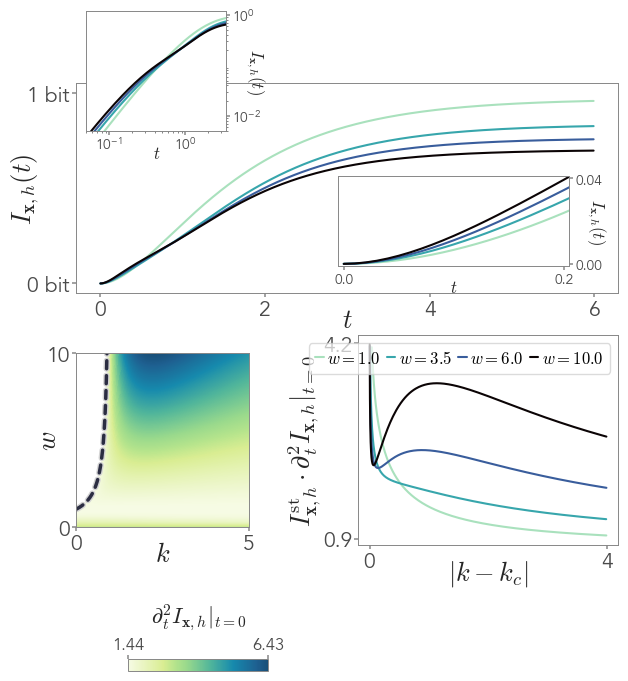

In [341]:
fig, axs = plt.subplot_mosaic([["time", "time"],
                               ["sder", "max"]],
                               figsize = (7, 6),
                               gridspec_kw = {'width_ratios': [1,1.5]})

plt.subplots_adjust(wspace=0.5, hspace=0.2)

axs["sder"].pcolormesh(Ks, Ws, SDer, cmap=cmap_SR, rasterized = True)
axs["sder"].set_xlabel('$k$', labelpad = -10)
axs["sder"].set_ylabel('$w$', labelpad = -12)
axs["sder"].set_aspect(0.5)

kcrit_toplot = 1 - 1/ws
ws_toplot = ws
ws_toplot[kcrit_toplot < 0] = np.nan
kcrit_toplot[kcrit_toplot < 0] = np.nan

axs["sder"].plot(kcrit_toplot, ws_toplot, ls = '--', color='#2b2d42', lw=2.5, label = "$k_c = 1 - 1/w$",
               path_effects=[pe.Stroke(linewidth=4.5, foreground='lightgray'), pe.Normal()],
               dashes=[2.3, 2])

axs["sder"].set_yticks([0, 10])
axs["sder"].set_xticks([0, 5])

sder_max = np.nanmax(SDer)
sder_min = np.nanmin(SDer)

cax = fig.add_axes([0.2, -0.1, 0.2, 0.02])
cbar = plt.colorbar(axs["sder"].collections[0], cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

cbar.set_ticks([sder_min, sder_max])
cbar.set_ticklabels([f'{sder_min:.2f}', f'{sder_max:.2f}'], fontsize = 12)
cbar.set_label(r'$\partial_t^2 I_{\mathbf{x},h}|_{t = 0}$', labelpad = 10, fontsize = 16)

colors_list = []
for idx_w in [50, 172, 300, 499]:
    k_crit = 1 - 1/ws[idx_w]
    ztoplot = Z[idx_w]
    xtoplot = Ks[idx_w] - k_crit
    ztoplot[ztoplot > 4.2] = np.nan
    ztoplot[xtoplot > 4] = np.nan
    
    axs["max"].plot(xtoplot, ztoplot, label = f'$w = {ws[idx_w]:.1f}$', color = my_cmap_continuous(idx_w/len(ws)))
    colors_list.append(my_cmap_continuous(idx_w/len(ws)))

axs["max"].set_xlabel('$|k - k_{c}|$', labelpad = -10)
axs["max"].set_xticks([0, 4])
axs["max"].set_yticks([0.9, 4.2])
axs["max"].set_ylabel(r'$I_{\mathbf{x},h}^\mathrm{st} \cdot \partial_t^2 I_{\mathbf{x},h}|_{t=0}$', labelpad = 0)

axs["max"].legend(loc = 'upper right', ncol = 4, fontsize = 12)

# plot mutual in time
for i, w in enumerate(wlist):
    axs["time"].plot(ts, I_t[i]/np.log(2), label = f'$w = {w}$', color = colors_list[i])

axs["time"].set_xlabel('$t$', labelpad = -10)
axs["time"].set_ylabel('$I_{\mathbf{x},h}(t)$', labelpad = -10)
axs["time"].set_xticks([0, 2, 4, 6])
axs["time"].set_yticks([0, 1])
axs["time"].set_yticklabels(["0 bit", "1 bit"])
axs["time"].set_ylim(-0.05, 1.05)

ax_inset1 = fig.add_axes([0.5, 0.575, 0.33, 0.15])
ax_inset1.tick_params(axis='both', which='major', labelsize=10)
fplot.right_ylabel(ax_inset1)
for i, w in enumerate(wlist):
    ax_inset1.plot(ts, I_t[i]/np.log(2), label = f'$w = {w}$', color = colors_list[i])

ax_inset1.set_xlim(-0.005, 0.205)
ax_inset1.set_ylim(-0.001, 0.041)
ax_inset1.set_yticks([0, 0.04])
ax_inset1.set_xticks([0, 0.2])

ax_inset2 = fig.add_axes([0.14, 0.8, 0.2, 0.2])
ax_inset2.tick_params(axis='both', which='major', labelsize=10)
fplot.right_ylabel(ax_inset2)

ax_inset2.set_facecolor('w')

for i, w in enumerate(wlist):
    ax_inset2.plot(ts, I_t[i]/np.log(2), label = f'$w = {w}$', color = colors_list[i])

ax_inset2.set_xlim(5e-2, 3.5)
ax_inset2.set_ylim(5e-3, 1.2)

ax_inset2.set_yscale('log')
ax_inset2.set_xscale('log')
ax_inset2.set_yticks([1e-2, 1e0])

for ax in [ax_inset1, ax_inset2]:
    ax.set_xlabel("$t$", labelpad = -5, fontsize = 12)
    ax.set_ylabel("$I_{\mathbf{x},h}(t)$", fontsize = 12, rotation = -90)

plt.savefig('figures/Figure3_draft.svg', dpi = 300, bbox_inches = 'tight')

plt.show()